In [1]:
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

In [14]:
def load_series(algorithm: str, upper_bound: str, task_name: str, root_dir: str):
    """
    kv_data has the following keys: 
    - 'S'
    - 'f(S)'
    - 'c(S)'
    - 'Lambda'
    - 'AF'
    """

    res = []
    # print(f"r:{root_dir}")
    for name in os.listdir(root_dir):
        # print(f"name:{name}")
        if not os.path.isdir(os.path.join(root_dir, name)):
            algo, up, task, b = name.strip()[:-5].split('-')
            # algo, up, task, b = name.strip()[:-5].split('-')
            # print(f"algo:{algo}, up:{up}, task:{task}, b:{b}, a:{algorithm}, u:{upper_bound}, t:{task_name}")
            
            if algo == algorithm and up == upper_bound and task == task_name:
                # print(name)
                file_path = os.path.join(root_dir, name)
                with open(file_path, "rb") as rd:
                    kv_data = pickle.load(rd)
                res.append( (eval(b), kv_data['f(S)'], kv_data['Lambda'], kv_data['AF'], kv_data['Time']) )
    res = sorted(res, key=lambda x: x[0])
    print(res)
    X, Y, Z, W, T = list(zip(*res))   # change it to two columns
    return X, Y, Z, W, T

def load_streaming_series(algorithm: str, upper_bound: str, task_name: str, root_dir: str):
    """
    kv_data has the following keys: 
    - 'S'
    - 'f(S)'
    - 'c(S)'
    - 'Lambda'
    - 'Time'
    """

    res = []
    for name in os.listdir(root_dir):
        if not os.path.isdir(os.path.join(root_dir, name)):
            algo, up, task, b = name.strip()[:-5].split('-')
            if algo == algorithm and up == upper_bound and task == task_name:
                # print(name)
                file_path = os.path.join(root_dir, name)
                with open(file_path, "rb") as rd:
                    kv_data = pickle.load(rd)
                res.append( (eval(b), kv_data['f(S)'], kv_data['Lambda'], kv_data['AF']) )
    res = sorted(res, key=lambda x: x[0])
    #print(res)
    X, Y, Z, W = list(zip(*res))   # change it to two columns
    return X, Y, Z, W


In [4]:
# alpha, beta, gamma, c2, d, c, e, MDAF
def load_custom_series(root_dir):
    """
    kv_data has the following keys: 
    - 'S'
    - 'f(S)'
    - 'c(S)'
    - 'Lambda'
    - 'AF'
    """

    res = []
    for name in os.listdir(root_dir):
        _, alpha, beta, gamma, n, seed = name.strip()[:-5].split('-')

            # print(name)
        file_path = os.path.join(root_dir, name)
        with open(file_path, "rb") as rd:
            kv_data = pickle.load(rd)
        res.append((alpha, beta, gamma, kv_data['c2'], kv_data['d'], kv_data['curvature'], kv_data['e'], kv_data['MDAF'],n, seed))

    res = sorted(res, key=lambda x: x[0])
    
    alpha, beta, gamma, c2, d, c, e, MDAF, n,seed = list(zip(*res))   # change it to two columns
    return alpha, beta, gamma, c2, d, c, e, MDAF,n, seed

Diagramming 

+ Each row has 2 columns.
+ Each row denotes a different task.
+ Y axis of 1st column denotes f(S) and Y axis of 2nd column denotes AF.
+ In each subfigure, X axis is budget. Different color denotes different (algorithm, upper-bound) combination.

Analysis Result
+ UB3 <= UB1
+ greedy max has better approximation ratio than mgreedy

a:0.2,b:0.1,g:0.5,n:100,s:20,MDAF:6.779928281519221
mean:3.7258434095580553


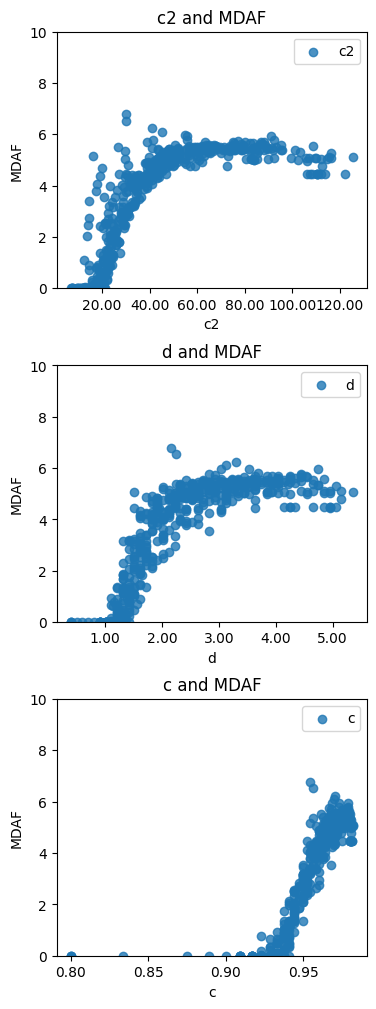

In [31]:
result_root_dir = "../result/archive/custom-coverage-ub77m"

# Each row contains one parameter
# alpha
# beta
# gamma
# seed
# c2
# d
# c
# e
alpha, beta, gamma, c2, d, c, e, MDAF,n, seed = load_custom_series(result_root_dir)

f = []

for i in range(0, len(c2)):
    f.append(c2[i]/d[i])

max_mdaf = 0
max_i = -1
for i in range(0, len(MDAF)):
    if MDAF[i] > max_mdaf:
        max_mdaf = MDAF[i]
        max_i = i
print(f"a:{alpha[max_i]},b:{beta[max_i]},g:{gamma[max_i]},n:{n[max_i]},s:{seed[max_i]},MDAF:{MDAF[max_i]}")
print(f"mean:{np.mean(MDAF)}")

max_mdaf = 0
max_config = None

parameters_names = [
    #"alpha", 
    #"beta", 
    #"gamma", 
    "c2", 
    "d", 
    "c", 
    #"e",
    #"f"
]

parameter_list = [
    #alpha, 
    #beta, 
    #gamma, 
    c2, 
    d, 
    c, 
    #e,
    #f
]

rows = len(parameters_names)
cols = 1
height, width = 4,4
fig, axes = plt.subplots(rows, 1, figsize=(cols * width, rows * height),
    gridspec_kw={
	'wspace' : 0.3,
	'hspace' : 0.3,
})


for ax, parameter_name, parameter in zip(axes, parameters_names, parameter_list):
    ax.set_xlabel(parameter_name)
    ax.set_ylabel("MDAF")
    ax.set_title(f"{parameter_name} and MDAF")

    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))

    ax.set_ylim(0.0, 10)

    ax.scatter(parameter, MDAF, label=parameter_name, alpha=0.8)

    ax.legend()
    
plt.show()

In [6]:
def combine_similar_elements(input: list, MDAF: list, eps: float = 0.01):
    assert len(input) == len(MDAF), "Inconsisitent"

    output = []

    output_mdaf_list = {}

    output_mdaf = []

    for idx in range(0, len(input)):
        e = input[idx]

        merged = False
        for center in output:
            if abs(e-center) < eps:
                merged = True
                output_mdaf_list[center].append(MDAF[idx])
                break

        if not merged:
            output.append(e)
            output_mdaf_list[e] = [MDAF[idx]]

    for center in output:
        mdaf_list = output_mdaf_list[center]
        output_mdaf.append(np.mean(mdaf_list))

    return output, output_mdaf

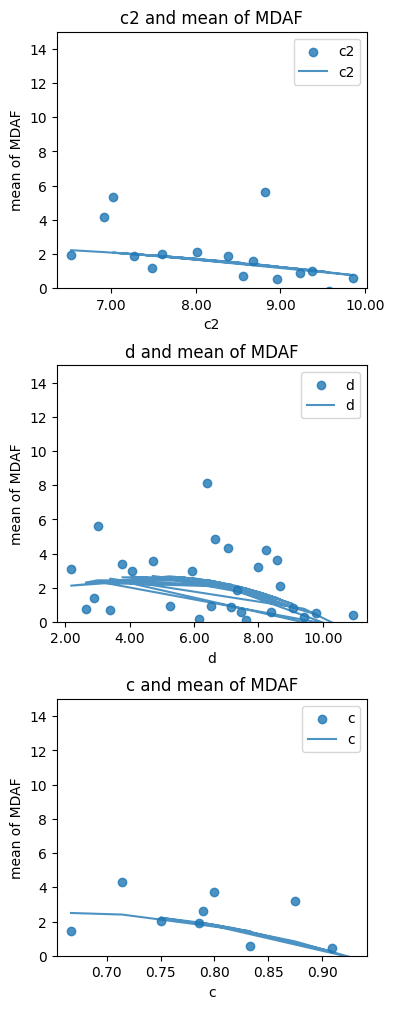

In [7]:
result_root_dir = "../result/custom-coverage-additive"

# Each row contains one parameter
# alpha
# beta
# gamma
# seed
# c2
# d
# c
# e
alpha, beta, gamma, c2, d, c, e, MDAF,n, seed = load_custom_series(result_root_dir)

f = []

for i in range(0, len(c2)):
    f.append(c2[i]/d[i])

c2, c2_mdaf = combine_similar_elements(c2, MDAF, eps=0.1)
d, d_mdaf = combine_similar_elements(d, MDAF, eps=0.1)
c, c_mdaf = combine_similar_elements(c, MDAF, eps=1e-4)
e, e_mdaf = combine_similar_elements(e, MDAF, eps=0.1)
f, f_mdaf = combine_similar_elements(f, MDAF, eps=0.1)

parameters_names = [
    #"alpha", 
    #"beta", 
    #"gamma", 
    "c2", 
    "d", 
    "c", 
    #"e",
    #"f"
]

parameter_list = [
    #alpha, 
    #beta, 
    #gamma, 
    c2, 
    d, 
    c, 
    #e,
    #f
]

MDAF_list = [
    c2_mdaf,
    d_mdaf,
    c_mdaf,
    #e_mdaf,
    #f_mdaf
]

rows = len(parameters_names)
cols = 1
height, width = 4,4
fig, axes = plt.subplots(rows, 1, figsize=(cols * width, rows * height),
    gridspec_kw={
	'wspace' : 0.3,
	'hspace' : 0.3,
})


for ax, parameter_name, parameter, vmdaf in zip(axes, parameters_names, parameter_list, MDAF_list):
    ax.set_xlabel(parameter_name)
    ax.set_ylabel("mean of MDAF")
    ax.set_title(f"{parameter_name} and mean of MDAF")

    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))

    ax.set_ylim(0.0, 15)

    f = np.polyfit(parameter, vmdaf, 2)
    p = np.poly1d(f)
    fvmdaf = p(parameter)

    ax.scatter(parameter, vmdaf, label=parameter_name, alpha=0.8)
    ax.plot(parameter, fvmdaf, label=parameter_name, alpha=0.8)

    ax.legend()
    
plt.show()

[(1.0, 0.0, 0.640584105268323, 0.0, 0.0), (2.0, 1.1363636363636365, 1.2260601880036888, 0.9268416407957107, 0.012248039245605469), (3.0, 1.1363636363636365, 1.62285832512156, 0.7002235615844761, 0.0), (4.0, 1.5909090909090908, 2.0195718007493286, 0.7877457440823893, 0.0), (5.0, 2.0454545454545454, 2.4162031996569624, 0.8465573366283706, 0.0), (6.0, 2.5, 2.800320742502862, 0.8927548769879687, 0.0), (7.0, 2.727272727272727, 3.1389427949509807, 0.8688507263208399, 0.0), (8.0, 3.1818181818181817, 3.4775648473990994, 0.914955815762254, 0.0), (9.0, 3.1818181818181817, 3.816186899847218, 0.8337689597817042, 0.0), (10.0, 3.8636363636363638, 4.1288903968417, 0.9357565816210001, 0.0), (11.0, 3.8636363636363638, 4.43737020793179, 0.8707040843087922, 0.0), (12.0, 4.318181818181818, 4.745850019021879, 0.9098858583550006, 0.012517452239990234), (13.0, 4.545454545454546, 5.052635572784196, 0.8996205010190012, 0.02514052391052246), (14.0, 5.0, 5.3514955455767526, 0.9343182587777207, 0.0135912895202636

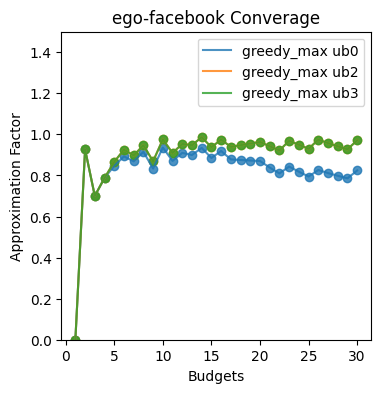

In [60]:
upper_bounds = ["ub1", "ub7", "ub7m"]
algos = ["greedy_max"]
# task_names = ["DblpGraphCoverage"]
task_names = ["FacebookGraphCoverage"]
# task_names = ["MovieFacilityLocation"]
# task_names = ["IdealMaxCovModel"]
# task_names = ["MovieRecommendation"]
# task_names = ["YoutubeCoverage"]
# task_names = ["ub77m"]
# task_names = ["AdultIncomeFeatureSelection"]
# task_names = ["SensorPlacement"]
# task_names = ["CalTechMaximization"]
# task_names = ["CitationCoverage"]
# task_names = ["CustomCoverage"]
# task_names = ["CustomCoverage"]
# task_names = ["CustomCoverage"]
# task_names = ["RevenueMax", "IdealMaxCovModel", "MovieRecommendation", "ImageSummarization"]

path_dict = {
    "DblpGraphCoverage":"dblp",
    "FacebookGraphCoverage":"facebook",
    "MovieFacilityLocation":"facility",
    "YoutubeCoverage":"youtube",
    "AdultIncomeFeatureSelection":"adult",
    "SensorPlacement":"sensor",
    "CalTechMaximization":"caltech",
    "CitationCoverage":"citation",
    "ub77m":"ub77m"
}

sample = 100
suffix = f""

task2title = {
    #"RevenueMax": "Revenue Maximization", 
    #"IdealMaxCovModel": "Maximum Coverage", 
    "MovieRecommendation": "Movie Recommendation", 
    #"ImageSummarization": "Image Summarization",
    "DblpGraphCoverage":"com-dblp Converage",
    "FacebookGraphCoverage":"ego-facebook Converage",
    "CustomCoverage":"custom coverage",
    "AdultIncomeFeatureSelection" : "income feature selection",
    "SensorPlacement": "sensor placement",
    "CalTechMaximization": "caltech maximization",
    "CitationCoverage": "citation coverage",
    "MovieFacilityLocation": "movie facility",
    "YoutubeCoverage": "youtube coverage",
    "ub77m":"custom coverage",
}

n = 100
result_root_dir = os.path.join("../result/archive-2", path_dict[task_names[0]] + suffix, f"{n}")

rows = len(task_names)
cols = 1
height, width = 4,4
fig, axes = plt.subplots(rows, cols, figsize=(cols * width, rows * height),
    gridspec_kw={
	'wspace' : 0.3,
	'hspace' : 0.3,
})

_, _, _, ub1, _ = load_series("greedy_max", "ub1", task_names[0], result_root_dir)
_, _, _, ub7, _ = load_series("greedy_max", "ub7m", task_names[0], result_root_dir)

ub1 = list(ub1)
ub7 = list(ub7)
if float('inf') in ub1:
    ub1.remove(float('inf'))   
if float('inf') in ub7:
    ub7.remove(float('inf'))
print(len(ub1))
print(len(ub7))

mdaf = [ub7[i] - ub1[i] for i in range(0, len(ub1))]

mmdadf = 0
si = -1
for i in range(0, len(ub1) - 10):
    t = np.mean([ub7[j] - ub1[j] for j in range(i, i+10)])
    if t > mmdadf:
        mmdadf = t
        si = i
print(len(mdaf))
print(f"best mdaf:{mmdadf}, max range:{si},{si+10}")

print(f"mean mdaf:{np.mean(mdaf)}, max mdaf:{np.max(mdaf)}")

n = False
if n:
    # left_ax, right_ax = axes
    # task_name = task_names[0]

    # left_ax.set_xlabel("Budgets")
    # left_ax.set_ylabel("Upper Bound used")
    # left_ax.set_title(task2title[task_name])
    # if task_name == "RevenueMax":
    #     left_ax.set_ylim(-5, 140)

    # right_ax.set_xlabel("Budgets")
    # right_ax.set_ylabel("Approximation Factor")
    # right_ax.set_ylim(0.0, 1.5)
    # right_ax.set_title(task2title[task_name])

    # sAF = []

    # upd = {
    #     "ub7":"ub3",
    #     "ub7m":"ub3m"
    # }

    # for algo in algos:
    #     for up in upper_bounds:
    #         X, Y, Z, W = load_series(algo, up, "CustomCoverage", result_root_dir)

    #         # function value: same algorithm should have same function value
    #         # left_ax.scatter(X, Y, label="{}".format(algo), alpha=0.5)

    #         left_ax.scatter(X, Z, label="{} {}".format(algo, upd[up]), alpha=0.8)
            
    #         # TODO: floor and ceiling
    #         #W = np.minimum(np.ones(shape=len(W)), np.array(W))
    #         #W = np.maximum(0.5 * np.ones(shape=len(W)), np.array(W))
    #         right_ax.scatter(X, W, label="{} {}".format(algo, upd[up]), alpha=0.8)
    #         sAF.append(sum(W))
    
    # print((sAF[1]-sAF[0])*10)

    # left_ax.legend()
    axs = axes
    task_name = task_names[0]

    axs.set_xlabel("Budgets")
    axs.set_ylabel("Approximation Factor")
    axs.set_ylim(0.0, 1.5)
    axs.set_title(task2title[task_name])

    sAF = []

    upd = {
        "ub1":"ub0",
        "ub7":"ub2",
        "ub7m":"ub3"
    }

    for algo in algos:
        for up in upper_bounds:
            X, Y, Z, W, T= load_series(algo, up, task_names[0], result_root_dir)

            # function value: same algorithm should have same function value
            # left_ax.scatter(X, Y, label="{}".format(algo), alpha=0.5)
            # axs.scatter(X, Z, label="{} {}".format(algo, upd[up]), alpha=0.8)
            
            # TODO: floor and ceiling
            #W = np.minimum(np.ones(shape=len(W)), np.array(W))
            #W = np.maximum(0.5 * np.ones(shape=len(W)), np.array(W))
            axs.scatter(X, W, alpha=0.8)
            axs.plot(X, W, label="{} {}".format(algo, upd[up]), alpha=0.8)
            sAF.append(sum(W))

    axs.legend()
    # middle_ax.legend()
    # right_ax.legend()
else:
    axs = axes
    task_name = task_names[0]

    axs.set_xlabel("Budgets")
    axs.set_ylabel("Time consumed")
    axs.set_title(task2title[task_name])

    sAF = []

    upd = {
        "ub1":"ub0",
        "ub7":"ub2",
        "ub7m":"ub3"
    }

    for algo in algos:
        for up in upper_bounds:
            X, Y, Z, W, T = load_series(algo, up, task_names[0], result_root_dir)

            # function value: same algorithm should have same function value
            # left_ax.scatter(X, Y, label="{}".format(algo), alpha=0.5)
            # axs.scatter(X, Z, label="{} {}".format(algo, upd[up]), alpha=0.8)
            
            # TODO: floor and ceiling
            #W = np.minimum(np.ones(shape=len(W)), np.array(W))
            #W = np.maximum(0.5 * np.ones(shape=len(W)), np.array(W))
            axs.scatter(X, T, alpha=0.8)
            axs.plot(X, T, label="{} {}".format(algo, upd[up]), alpha=0.8)
            sAF.append(sum(W))

    axs.legend()
    # middle_ax.legend()
    # right_ax.legend()
plt.show()

[(1.0, 0.0, 3.4505721202222097, 0.0), (2.0, 5.389528596043696, 6.901144240444419, 0.7809615924933372), (3.0, 5.389528596043696, 10.351716360666629, 0.5206410616622248), (4.0, 12.472251726769073, 13.654270341717368, 0.9134323119898309), (5.0, 12.472251726769073, 16.720832574445705, 0.7459109270569637), (6.0, 17.58340527962188, 19.493968901027976, 0.9019920657970606), (7.0, 17.58340527962188, 22.09324715287679, 0.7958723838986395), (8.0, 22.07498600062679, 23.842478299773155, 0.9258679287898028), (9.0, 22.07498600062679, 25.43596597005613, 0.8678650548052323), (10.0, 23.921251448962067, 27.029453640339103, 0.8850068435442471), (11.0, 23.921251448962067, 28.62294131062208, 0.835737012117787), (12.0, 28.047483384297042, 29.839520892606643, 0.9399441594669298), (13.0, 28.047483384297042, 30.898503567063873, 0.907729506169164), (14.0, 29.893748832632326, 31.957486241521107, 0.9354224110966698), (15.0, 29.893748832632326, 33.016468915978336, 0.9054193199371854), (16.0, 31.59087790934284, 33.8

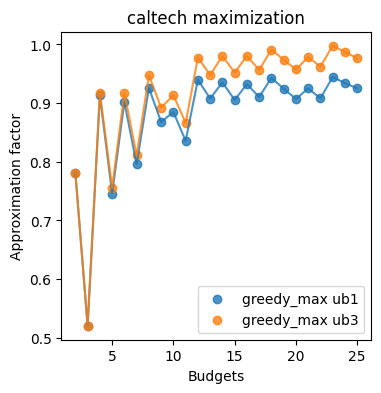

In [38]:
upper_bounds = ["ub1","ub7"]
algos = ["greedy_max"]
# task_names = ["DblpGraphCoverage"]
# task_names = ["FacebookGraphCoverage"]
# task_names = ["MovieFacilityLocation"]
# task_names = ["IdealMaxCovModel"]
# task_names = ["MovieRecommendation"]
# task_names = ["YoutubeCoverage"]
# task_names = ["AdultIncomeFeatureSelection"]
# task_names = ["SensorPlacement"]
task_names = ["CalTechMaximization"]
# task_names = ["CitationCoverage"]
# task_names = ["CustomCoverage"]
# task_names = ["CustomCoverage"]
# task_names = ["CustomCoverage"]
# task_names = ["RevenueMax", "IdealMaxCovModel", "MovieRecommendation", "ImageSummarization"]

path_dict = {
    "DblpGraphCoverage":"dblp",
    "FacebookGraphCoverage":"facebook",
    "MovieFacilityLocation":"facility",
    "YoutubeCoverage":"youtube",
    "AdultIncomeFeatureSelection":"adult",
    "SensorPlacement":"sensor",
    "CalTechMaximization":"caltech",
    "CitationCoverage":"citation"
}

suffix = "-fixed-minus"
upd = {
    "ub1":"ub1",
    "ub7":"ub3"
}

task2title = {
    #"RevenueMax": "Revenue Maximization", 
    #"IdealMaxCovModel": "Maximum Coverage", 
    "MovieRecommendation": "Movie Recommendation", 
    #"ImageSummarization": "Image Summarization",
    "DblpGraphCoverage":"com-dblp Converage",
    "FacebookGraphCoverage":"ego-facebook Converage",
    # "CustomCoverage":"custom Coverage"
    "AdultIncomeFeatureSelection" : "income feature selection",
    "SensorPlacement": "sensor placement",
    "CalTechMaximization": "caltech maximization",
    "CitationCoverage": "citation coverage",
    "MovieFacilityLocation": "movie facility",
    "YoutubeCoverage": "youtube coverage"
}


result_root_dir = "../result/archive/" + path_dict[task_names[0]] + suffix

height, width = 4,4
fig, axs = plt.subplots(figsize=(width, height),
    gridspec_kw={
	'wspace' : 0.3,
	'hspace' : 0.3,
})

_, _, _, ub1 = load_series("greedy_max", "ub1", task_names[0], result_root_dir)
_, _, _, ub7 = load_series("greedy_max", "ub7", task_names[0], result_root_dir)

ub1 = list(ub1)
ub7 = list(ub7)
if float('inf') in ub1:
    ub1.remove(float('inf'))   
if float('inf') in ub7:
    ub7.remove(float('inf'))
print(len(ub1))
print(len(ub7))

mdaf = [ub7[i] - ub1[i] for i in range(0, len(ub1))]

print(len(mdaf))

print(f"mean mdaf:{np.mean(mdaf)}, max mdaf:{np.max(mdaf)}")

task_name = task_names[0]

axs.set_xlabel("Budgets")
axs.set_ylabel("Approximation factor")
axs.set_title(task2title[task_name])
if task_name == "RevenueMax":
    left_ax.set_ylim(-5, 140)



for algo in algos:
    for up in upper_bounds:
        X, Y, Z, W = load_series(algo, up, task_name, result_root_dir)

        # function value: same algorithm should have same function value
        # left_ax.scatter(X, Y, label="{}".format(algo), alpha=0.5)

        # left_ax.scatter(X, Z, label="{} {}".format(algo, up), alpha=0.8)
        
        X = X[1:]
        W = W[1:]

        # TODO: floor and ceiling
        #W = np.minimum(np.ones(shape=len(W)), np.array(W))
        #W = np.maximum(0.5 * np.ones(shape=len(W)), np.array(W))
        axs.scatter(X, W, label="{} {}".format(algo, upd[up]), alpha=0.8)
        axs.plot(X, W, alpha=0.8)

axs.legend()
# middle_ax.legend()
# right_ax.legend()
plt.show()

# Misc

Categories
+ Upper bound 1 and 2
+ MGreedy and GreedyMax

In [ ]:
def load_series(algorithm, upper_bound):
    res = []
    for name in os.listdir("./result"):
        algo, up, b = name.strip()[:-5].split('-')
        if algo == algorithm and up == upper_bound:
            # print(name)
            file_path = "./result/{}".format(name)
            with open(file_path, "rb") as rd:
                kv_data = pickle.load(rd)
            res.append( (eval(b), kv_data['AF']) )
    res = sorted(res, key=lambda x: x[0])
    X, Y = list(zip(*res))   # change it to two columns
    return X, Y

upper_bounds = ["ub1", "ub3"]
algos = ["modified_greedy", "greedy_max"]
X, Y = load_series("modified_greedy", "ub1")

In [ ]:
face_colors = [
    ['#FB4570', 'none', '#81B622'],
    ['#145DA0', 'none', '#EFEBE0'],
]

edge_colors = [
    ['#FB4570', '#3D550C', '#81B622'],
    ['#145DA0', '#FB8DA0', '#FB8DA0'],
]

fig, axes = plt.subplots(1,2, figsize=(10,5))


for r, algo in enumerate(algos):
    ax = axes[r]
    for c, up in enumerate(upper_bounds):
        X, Y = load_series(algo, up)
        ax.scatter(X, Y, s=80, facecolors=face_colors[r][c], edgecolors=edge_colors[r][c], alpha=0.6, label='{} {}'.format(algo, up))
        ax.set_xlabel("Budgets")
        ax.set_ylabel("Approximation Ratio")
        ax.set_ylim([0., 1.2])
        ax.axhline(y = 1.0, color='r', linestyle='-')
        ax.legend()
        ax.set_title("Budgeted Maximum Coverage")
plt.show()

In [ ]:
def load_series(algorithm, upper_bound):
    res = []
    for name in os.listdir("./result"):
        algo, up, b = name.strip()[:-5].split('-')
        if algo == algorithm and up == upper_bound:
            # print(name)
            file_path = "./result/{}".format(name)
            with open(file_path, "rb") as rd:
                kv_data = pickle.load(rd)
            res.append( (eval(b), kv_data['Lambda']) )
    res = sorted(res, key=lambda x: x[0])
    X, Y = list(zip(*res))   # change it to two columns
    return X, Y

fig, axes = plt.subplots(1,2, figsize=(10,5))

for r, algo in enumerate(algos):
    ax = axes[0]
    for c, up in enumerate(upper_bounds):
        X, Y = load_series(algo, up)
        print(algo, up)
        print(Y)
        ax.plot(X, Y, label="{} {}".format(algo, up))
        ax.set_xlabel("Budgets")
        ax.set_ylabel("Function Value")
        ax.legend()
        ax.set_title("Budgeted Maximum Coverage")
plt.show()